In [1]:
import numpy as np
import time

class MLP():
    
    def __init__(self, X, Y, X_val, Y_val, hidden_layer_sizes=[128, 64, 32], loss_fn='bce'):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        self.Y = np.squeeze(np.eye(10)[Y.astype(int).reshape(-1)])
        self.X_val = np.concatenate((X_val, np.ones((X_val.shape[0], 1))), axis=1)
        self.Y_val = np.squeeze(np.eye(10)[Y_val.astype(int).reshape(-1)])
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]] + self.hidden_layer_sizes + [self.Y.shape[1]])
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss, self.train_acc, self.val_loss, self.val_acc, self.train_time, self.tot_time]
        self.loss_fn = loss_fn
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))
    
    def __softmax(self,x):
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __relu(self, x):
        return np.maximum(0, x)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        if self.loss_fn == 'bce':
            return ((-np.log(y_pred))*y).sum(axis=1).mean()
        elif self.loss_fn == 'cce':
            return -np.mean(np.sum(y * np.log(y_pred), axis=1))
        else:
            return "madhurchud"
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __relu_prime(self,h):
        # Compute the derivative of relu 
        return np.where(h > 0, 1, 0)
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__relu(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        # Update the weights of the network through back-propagation
        delta_t = (self.__out - batch_y)*self.__relu_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__relu_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")
    

In [2]:
from sklearn import datasets
from tensorflow import keras

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Select only the first 1000 samples
x_train, y_train = x_train[:1000], y_train[:1000]
x_test, y_test = x_test[:1000], y_test[:1000]

# Normalize data (each pixel starts as int 0-255; we want it to be a float between 0 and 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [12]:
x_train_flat.shape

(1000, 784)

In [5]:
model = keras.models.Sequential([
    keras.layers.Dense(10, activation='softmax') # output layer
])

# we'll use sparse_categorical_crossentropy as the loss function
LOSS_FN = keras.losses.sparse_categorical_crossentropy

# compile the model with standard backprop training algorithm called 'adam'
model.compile(optimizer='adam',loss=LOSS_FN,metrics=['accuracy'])

# train on training data, and validate on test data
# we'll train for 5 epochs
model.fit(x_train_flat, y_train, epochs=5, validation_data=(x_test_flat, y_test))



Epoch 1/5


32/32 [==============================] - 1s 7ms/step - loss: 1.9379 - accuracy: 0.3850 - val_loss: 1.6408 - val_accuracy: 0.5920
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 1.2940 - accuracy: 0.7430 - val_loss: 1.2655 - val_accuracy: 0.7090
Epoch 3/5
32/32 [==============================] - 0s 2ms/step - loss: 0.9701 - accuracy: 0.8150 - val_loss: 1.0650 - val_accuracy: 0.7390
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 0.7978 - accuracy: 0.8500 - val_loss: 0.9403 - val_accuracy: 0.7590
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.8650 - val_loss: 0.8598 - val_accuracy: 0.7790


In [6]:
modelMLP = MLP(x_train_flat,y_train,x_test_flat,y_test,loss_fn='cce')
modelMLP.train(batch_size=32,epochs=500,lr=1)

Epoch 1: loss = nan | acc = 0.101 | val_loss = nan | val_acc = 0.085 | train_time = 0.038 | tot_time = 0.046
Epoch 2: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.064 | tot_time = 0.067
Epoch 3: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.029 | tot_time = 0.029


C:\Users\K-Gen\AppData\Local\Temp\ipykernel_7568\3160381693.py:30: RuntimeWarning: overflow encountered in exp
  exponent = np.exp(x)
C:\Users\K-Gen\AppData\Local\Temp\ipykernel_7568\3160381693.py:31: RuntimeWarning: invalid value encountered in divide
  return exponent/exponent.sum(axis=1,keepdims=True)
C:\Users\K-Gen\AppData\Local\Temp\ipykernel_7568\3160381693.py:41: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.sum(y * np.log(y_pred), axis=1))
C:\Users\K-Gen\AppData\Local\Temp\ipykernel_7568\3160381693.py:41: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(np.sum(y * np.log(y_pred), axis=1))


Epoch 4: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.031 | tot_time = 0.031
Epoch 5: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.03 | tot_time = 0.03
Epoch 6: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.021 | tot_time = 0.021
Epoch 7: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.043 | tot_time = 0.043
Epoch 8: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.022 | tot_time = 0.022
Epoch 9: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.031 | tot_time = 0.031
Epoch 10: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.031 | tot_time = 0.031
Epoch 11: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.04 | tot_time = 0.045
Epoch 12: loss = nan | acc = 0.097 | val_loss = nan | val_acc = 0.085 | train_time = 0.03 | tot_time = 0.031
Epoch 13: loss = nan

In [7]:
x_train_flat.shape[0]

1000

AttributeError: 'Sequential' object has no attribute 'train_loss'

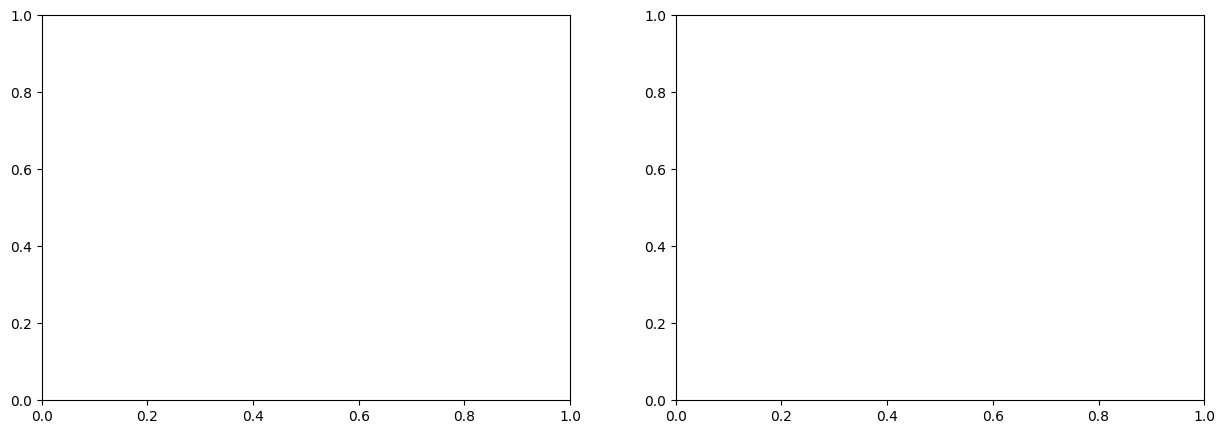

In [8]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

In [ ]:
from joblib.numpy_pickle_utils import xrange
from numpy import *

class binaryClassifierNeuron(): 
	def __init__(self): 
		# Generate random numbers 
		random.seed(1)
		self.lr = 0.1 

		# Assign random weights to a 3 x 1 matrix, 
		self.synaptic_weights = 2 * random.random((784, 1)) - 1

	# The Sigmoid function 
	def __sigmoid(self, x): 
		return 1 / (1 + exp(-x)) 

	# The derivative of the Sigmoid function. 
	# This is the gradient of the Sigmoid curve. 
	def __sigmoid_derivative(self, x): 
		return x * (1 - x) 

	# Train the neural network and adjust the weights each time. 
	def train(self, inputs, outputs, training_iterations): 
		for iteration in xrange(training_iterations): 
			# Pass the training set through the network. 
			output = self.predict(inputs) 

			# Calculate the error 
			error = outputs - output 

			# Adjust the weights by a factor 
			factor = dot(inputs.T, error * self.__sigmoid_derivative(output)) 
			self.synaptic_weights += (factor * self.lr) 

		# The neural network thinks. 

	def predict(self, inputs): 
		return self.__sigmoid(dot(inputs, self.synaptic_weights)) 

class multiClassifierNeuron():
	def __init__(self): 
		# Generate random numbers 
		random.seed(1)
		self.lr = 0.1 

		# Assign random weights to a 3 x 1 matrix, 
		self.synaptic_weights = 2 * random.random((784, 1)) - 1

	def __softmax(self, x):
		e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
		return e_x / np.sum(e_x, axis=-1, keepdims=True)
	
	def __softmax_derivative(self, outputs):
		return outputs * (1 - outputs)
	
	def __categorical_cross_entropy(self, outputs, targets):
		return -np.sum(targets * np.log(outputs + 1e-8), axis=1)
	
	def train(self, inputs, targets, training_iterations):
		for iteration in xrange(training_iterations):
			# Pass the training set through the network.
			outputs = self.predict(inputs)
			
			# Calculate the error/loss
			error = self.__categorical_cross_entropy(outputs, targets)
			
			# Adjust the weights by a factor
			factor = dot(inputs.T, (outputs - targets) * self.__softmax_derivative(outputs))
			self.synaptic_weights -= factor * self.lr

	def predict(self, inputs): 
		return self.__softmax(dot(inputs, self.synaptic_weights)) 


In [ ]:
# 	# Initialize 
# neural_network = neuron() 

# 	# The training set. 
# inputs = array([[0, 1, 1,0], [1, 0, 0,0], [1, 0, 1,0]]) 
# outputs = array([[1, 0, 1]]).T 

# 	# Train the neural network 
# neural_network.train(inputs, outputs, 1000) 

# 	# Test the neural network with a test example. 
# print(neural_network.predict([1,0,1,0])) 

In [ ]:
# Create an instance of the neuron class
#neural_network = binaryClassifierNeuron()
neural_network = multiClassifierNeuron()

# Train the neural network
print("Training the neural network...")
neural_network.train(x_train_flat, y_train.reshape(y_train.shape[0], 1), 10000)

# Make predictions on the test set
print("Testing the neural network...")
predictions = neural_network.predict(x_test_flat)



Training the neural network...
Testing the neural network...


In [ ]:
for i in range(len(predictions)-1):
    print("prediction of " + str(i) + " is " + str(predictions[i]))

prediction of 0 is [1.]
prediction of 1 is [1.]
prediction of 2 is [1.]
prediction of 3 is [1.]
prediction of 4 is [1.]
prediction of 5 is [1.]
prediction of 6 is [1.]
prediction of 7 is [1.]
prediction of 8 is [1.]
prediction of 9 is [1.]
prediction of 10 is [1.]
prediction of 11 is [1.]
prediction of 12 is [1.]
prediction of 13 is [1.]
prediction of 14 is [1.]
prediction of 15 is [1.]
prediction of 16 is [1.]
prediction of 17 is [1.]
prediction of 18 is [1.]
prediction of 19 is [1.]
prediction of 20 is [1.]
prediction of 21 is [1.]
prediction of 22 is [1.]
prediction of 23 is [1.]
prediction of 24 is [1.]
prediction of 25 is [1.]
prediction of 26 is [1.]
prediction of 27 is [1.]
prediction of 28 is [1.]
prediction of 29 is [1.]
prediction of 30 is [1.]
prediction of 31 is [1.]
prediction of 32 is [1.]
prediction of 33 is [1.]
prediction of 34 is [1.]
prediction of 35 is [1.]
prediction of 36 is [1.]
prediction of 37 is [1.]
prediction of 38 is [1.]
prediction of 39 is [1.]
prediction

In [ ]:
len(inputs[0])

NameError: name 'inputs' is not defined